In [1]:
%load_ext blackcellmagic

In [2]:
%load_ext notexbook

%texify

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
import torch
import numpy as np

SEED = 123456

np.random.seed(SEED)

torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
torch.cuda.is_available()

False

In [6]:
import sys

sys.path.append("../")

## Loading Dataset

In [7]:
from backend.datasets.fer import FER
from backend.datasets.ferplus import FERPlus
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor, Resize, Compose
from torchvision.transforms import Lambda, RandomAffine, Normalize

In [8]:
fer_training = FERPlus(root="./", download=True, split="train", 
                   transform=ToTensor())

fer_validation = FERPlus(root="./", split="validation", transform=ToTensor())
fer_test = FERPlus(root="./", split="test", transform=ToTensor())

In [9]:
len(fer_training), len(fer_validation), len(fer_test)

(21811, 2729, 2862)

In [10]:
## LOADERS

BATCH_SIZE = 256

train_loader = DataLoader(fer_training, batch_size=BATCH_SIZE, 
                          shuffle=False, num_workers=2, drop_last=False)

valid_loader = DataLoader(fer_validation, batch_size=BATCH_SIZE, 
                          shuffle=False, num_workers=2, drop_last=False)

test_loader = DataLoader(fer_test, batch_size=BATCH_SIZE, 
                         shuffle=False, num_workers=2, drop_last=False)

## Auto-Encoder Model (with Training)

### Model (Encoder/Decoder)

In [11]:
import torch
from torch import nn
from collections import OrderedDict


class VGGEncoder(nn.Module):
    def __init__(self, in_channels: int = 1, d_latent_space: int = 128):
        super(VGGEncoder, self).__init__()

        self.conv_enc1 = self._enc_block(in_channels, 64, name="enc1")
        self.conv_enc2 = self._enc_block(64, 128, name="enc2")
        self.conv_enc3 = self._enc_block(128, 256, name="enc3")

        self.fc_enc = nn.Sequential(
            OrderedDict(
                [
                    ("fc-enc-1", nn.Linear(256 * 6 * 6, 1024)),
                    ("fc-enc-relu-1", nn.ReLU(inplace=True)),
                    ("fc-enc-2", nn.Linear(1024, 256)),
                    ("fc-enc-relu-2", nn.ReLU(inplace=True)),
                    # ("fc-enc-drop-1", nn.Dropout(0.25)),
                    ("latent", nn.Linear(256, d_latent_space)),
                ]
            )
        )

    def forward(self, x):
        x = self.conv_enc1(x)
        x = self.conv_enc2(x)
        x = self.conv_enc3(x)
        x = torch.flatten(x, 1)
        return self.fc_enc(x)

    @staticmethod
    def _enc_block(in_channels: int, features: int, name: str):
        layers = [
            (
                f"{name}-conv",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=features,
                    kernel_size=(3, 3),
                    padding=1,
                    bias=False,
                ),
            ),
            (f"{name}-relu", nn.ReLU(inplace=True)),
            (
                f"{name}-pool",
                nn.MaxPool2d(kernel_size=(2, 2)),
            ),
            # (
            #     f"{name}-dropout",
            #     nn.Dropout2d(p=0.25),
            # )
        ]
        return nn.Sequential(OrderedDict(layers))


class VGGDecoder(nn.Module):
    
    def __init__(self, out_channels: int = 1, d_latent_space: int = 128,):
        super(VGGDecoder, self).__init__()
        self.fc_dec = nn.Sequential(
            OrderedDict(
                [
                    ("latent", nn.Linear(d_latent_space, 256)),
                    ("latent-relu", nn.ReLU(inplace=True)),
                    # ("drop-dec-1", nn.Dropout(0.25)),
                    ("fc-dec-1", nn.Linear(256, 1024)),
                    ("fc-dec-1-relu", nn.ReLU(inplace=True)),
                    ("fc-dec-2", nn.Linear(1024, 256 * 6 * 6)),
                    ("fc-dec-2-relu", nn.ReLU(inplace=True)),
                ]
            )
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 6, 6))

        self.conv_dec1 = self._dec_block(256, 128, name="dec1")
        self.conv_dec2 = self._dec_block(128, 64, name="dec2")
        self.conv_dec3 = self._dec_block(64, 1, name="dec3")
        
    def forward(self, x):
        x = self.fc_dec(x)
        x = self.unflatten(x)
        x = self.conv_dec1(x)
        x = self.conv_dec2(x)
        x = self.conv_dec3(x)
        return torch.sigmoid(x)

    @staticmethod
    def _dec_block(in_channels: int, features: int, name: str):
        layers = [
            # (
            #     f"{name}-conv-transposed",
            #     nn.ConvTranspose2d(
            #         in_channels=in_channels,
            #         out_channels=features,
            #         kernel_size=(3, 3),
            #         stride=2, padding=1,
            #         output_padding=1,
            #     ),
            # ),
            (
                f"{name}-conv",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=features,
                    kernel_size=(3, 3),
                    padding=1,
                    bias=False,
                ),
            ),
            (f"{name}-relu", nn.ReLU(inplace=True)),
            (
                f"{name}-unpool",
                nn.Upsample(scale_factor=(2, 2)),
            ),
            # (
            #     f"{name}-dropout",
            #     nn.Dropout2d(p=0.25),
            # )
        ]
        return nn.Sequential(OrderedDict(layers))

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
device

device(type='cpu')

In [14]:
# Move both the encoder and the decoder to the selected device
# Initialize the two networks
D = 128

encoder = VGGEncoder(d_latent_space=D).to(device)
decoder = VGGDecoder(d_latent_space=D).to(device)

## Dimension Reduction with Trained Model

### 1. Load AutoEncoder

To generate a _latent_ representation of each face (image) in the dataset in an **Unsupervised** fashion (i.e. data dependent only)

![AutoEncoder Example](https://miro.medium.com/max/1200/1*nqzWupxC60iAH2dYrFT78Q.png)

<span class="fn">Source: "Basics of Autoencoders", Medium.com</span>

In [15]:
AUTO_ENC_MODEL_FILE = "./models/vggfer_plus_encoder.pth"

In [16]:
enc_weights = torch.load(AUTO_ENC_MODEL_FILE, map_location=device)
encoder.load_state_dict(enc_weights)

<All keys matched successfully>

In [17]:
from tqdm.notebook import tqdm

In [18]:
def prepare_data_for_umap(dataloader):
    X_enc = list()
    y_enc = list()
    with torch.no_grad():
        encoder.eval()
        for batch, emotions in tqdm(dataloader):
            reco_batch = encoder(batch.to(device))
            X_enc.append(reco_batch.detach().cpu().numpy())
            y_enc.append(emotions.numpy())
        X_enc = np.vstack(X_enc)
        y_enc = np.hstack(y_enc)
    return X_enc, y_enc


In [19]:
X_train_enc, y_train = prepare_data_for_umap(train_loader)

  0%|          | 0/86 [00:00<?, ?it/s]

In [20]:
X_valid_enc, y_valid = prepare_data_for_umap(valid_loader)
X_test_enc, y_test = prepare_data_for_umap(test_loader)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [21]:
X_train_enc.shape, X_valid_enc.shape, X_test_enc.shape

((21811, 128), (2729, 128), (2862, 128))

### 2. UMAP Dimension Reduction

From the latest space (i.e. $\mathbb{R}^{128}$) we apply a _Dimension Reduction_ technique (i.e. `UMAP`) to generate a two-dimensional embedding, so that:
- (a) samples can be visualised; 
- (b) samples will potentially appear better separated.

In [22]:
from umap import UMAP
from joblib import dump, load

In [23]:
from pathlib import Path

UMAP_TRAIN_TRAINED = Path("./models/umap_ferplus_train.joblib")
UMAP_VALID_TRAINED = Path("./models/umap_ferplus_valid.joblib")
UMAP_TEST_TRAINED = Path("./models/umap_ferplus_test.joblib")

In [24]:
if UMAP_TRAIN_TRAINED.exists():
    umap_train = load(UMAP_TRAIN_TRAINED)
else:
    umap_train = UMAP(n_components=2, random_state=SEED, n_neighbors=35, min_dist=0.0)
    umap_train = umap_train.fit(X_train_enc, y=y_train)
    dump(umap_train, UMAP_TRAIN_TRAINED)
    
if UMAP_VALID_TRAINED.exists():
    umap_valid = load(UMAP_VALID_TRAINED)
else:
    umap_valid = UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.0)
    umap_valid = umap_valid.fit(X_valid_enc, y=y_valid)
    dump(umap_valid, UMAP_VALID_TRAINED)
    
if UMAP_TEST_TRAINED.exists():
    umap_test = load(UMAP_TEST_TRAINED)
else:
    umap_test = UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.0)
    umap_test = umap_test.fit(X_test_enc, y=y_test)
    dump(umap_test, UMAP_TEST_TRAINED)

In [25]:
from plotting import Embedding

In [26]:
fer_training.classes

['neutral',
 'happy',
 'surprise',
 'sad',
 'angry',
 'disgust',
 'fear',
 'contempt',
 'not-human-face',
 'unknown']

In [27]:
embedding_train = Embedding(
    data=umap_train.transform(X_train_enc),
    labels=y_train,
    partition="train",
    classes=fer_training.classes[:-2],
    is_ferplus=True
)
embedding_valid = Embedding(
    data=umap_valid.transform(X_valid_enc),
    labels=y_valid,
    partition="validation",
    classes=fer_training.classes[:-2],
    is_ferplus=True
)
embedding_test = Embedding(
    data=umap_test.transform(X_test_enc),
    labels=y_test,
    partition="test",
    classes=fer_training.classes[:-2],
    is_ferplus=True
)

---

### 3. Interactive Visualisation

In [28]:
from bokeh.io import show, output_notebook
from bokeh.resources import CDN

output_notebook(CDN)

Loading BokehJS ...

**NOTE** Please set the following constant to `True` to enable the lay-hover effect with faces preview during plot navigation. This feature has been temporarily disabled as resulting notebook would exceed the size-limits imposed by GitHub

In [29]:
WITH_HOVER = False  

In [30]:
from plotting import plot_embedding

#### Training Set

In [ ]:
# Suppressed as notebook content would exceed size limit imposed by GitHub


train_plot = plot_embedding(embedding_train, with_hover=WITH_HOVER)
train_plot.legend.location = "top_left"
show(train_plot)

#### Validation Set 

In [ ]:
valid_plot = plot_embedding(embedding_valid, with_hover=WITH_HOVER)
show(valid_plot)

#### Test Set

In [ ]:
test_plot = plot_embedding(embedding_test, with_hover=WITH_HOVER)
show(test_plot)

### 4. Selecting Candidates per each Emotion (cluster)

So here's the plan: 
1. for each emotion (cluster), calculate the `centroid`
2. take the top `10` data points closest to each `centroid`

In [34]:
from plotting import plot_centroids, plot_neighbours, plot_reference_images

In [35]:
from plotting.utils import get_neighbours

#### Training Set


**Note** Disabled to keep the size of the notebook low. 
Please de-comment to run locally!

In [ ]:
train_plot_with_centroids = plot_centroids(
    embedding_fig=train_plot, embedding=embedding_train
)
show(train_plot_with_centroids)

In [ ]:
train_neighbours = plot_neighbours(embedding=embedding_train)
show(train_neighbours)

In [ ]:
plot_reference_images(embedding_train)

In [39]:
_, neighs_per_emotion_indices = get_neighbours(embedding_train, n_neighbours=10)

In [40]:
for emotion in neighs_per_emotion_indices:
    print(f"{emotion}: {list(neighs_per_emotion_indices[emotion])}")

neutral: [15910, 3590, 16557, 8492, 13377, 6778, 14524, 12679, 21701, 12604]
happy: [421, 17271, 18556, 20360, 16786, 10611, 14968, 15480, 14471, 4455]
surprise: [7043, 8280, 18914, 9654, 10715, 7170, 16359, 1733, 16156, 15902]
sad: [13932, 19968, 4636, 6195, 865, 14629, 3567, 19163, 10395, 2406]
angry: [7182, 17275, 21314, 20807, 2652, 16957, 10740, 8337, 16738, 1231]
disgust: [12046, 14242, 19588, 5463, 16176, 1579, 20427, 6745, 16523, 7733]
fear: [18680, 6770, 15975, 7680, 6733, 12776, 8586, 14739, 8751, 3018]
contempt: [583, 20448, 17578, 3427, 15160, 11383, 19095, 578, 15944, 11770]


In [41]:
for i, emotion in enumerate(neighs_per_emotion_indices):
    print(f"Emotion {emotion} - {i}")
    for index in list(neighs_per_emotion_indices[emotion]):
        print(fer_training[index][1], end=", ")
    print()

Emotion neutral - 0
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
Emotion happy - 1
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
Emotion surprise - 2
2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
Emotion sad - 3
3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
Emotion angry - 4
4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 
Emotion disgust - 5
5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 
Emotion fear - 6
6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 
Emotion contempt - 7
7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 


In [42]:
embedding_train.data.shape

(21811, 2)

In [43]:
embedding_train.labels.shape

(21811,)

#### Validation Set 

In [44]:
valid_plot_with_centroids = plot_centroids(embedding_fig=valid_plot, embedding=embedding_valid)
show(valid_plot_with_centroids)

In [45]:
valid_neighbours = plot_neighbours(embedding=embedding_valid, n_neighbours=7)
show(valid_neighbours)

REFERENCE IMAGES FOR VALIDATION DATASET
Selected Representatives for Emotion neutral


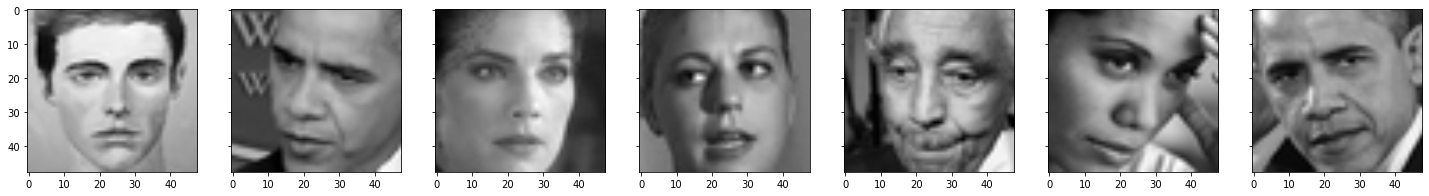

Selected Representatives for Emotion happy


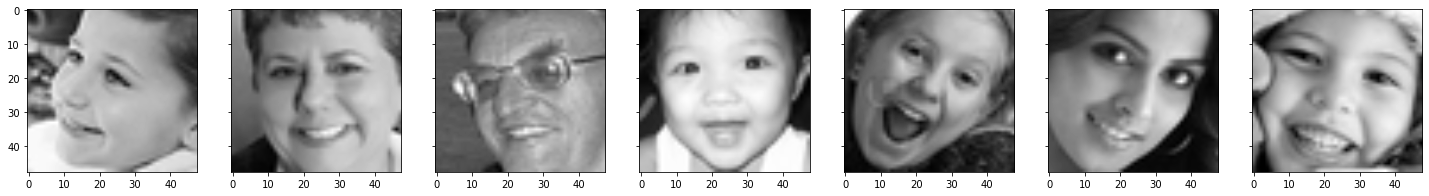

Selected Representatives for Emotion surprise


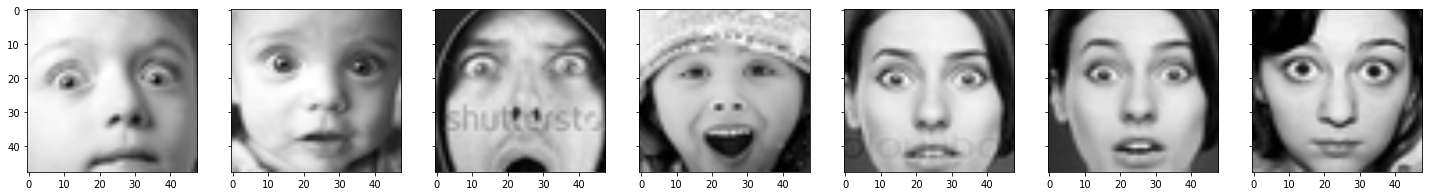

Selected Representatives for Emotion sad


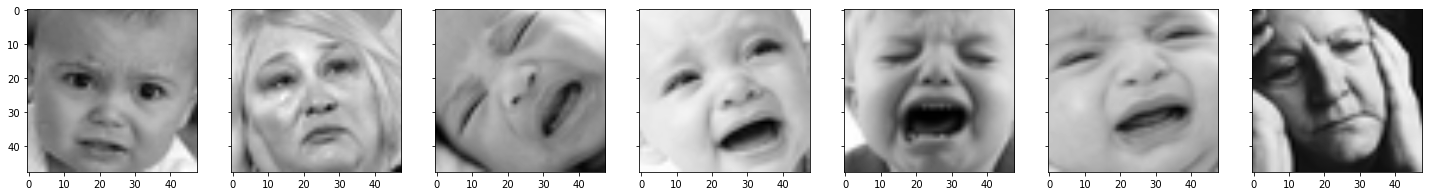

Selected Representatives for Emotion angry


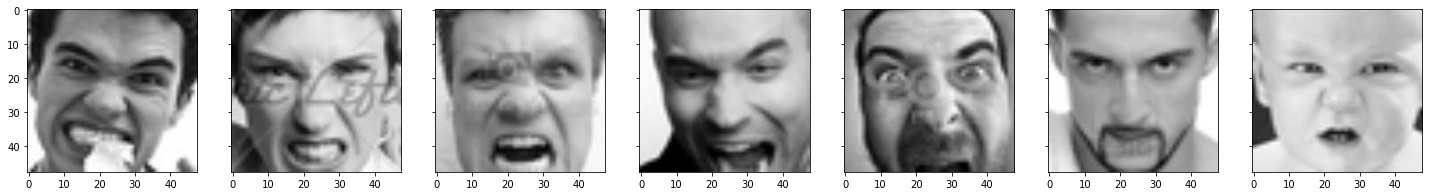

Selected Representatives for Emotion disgust


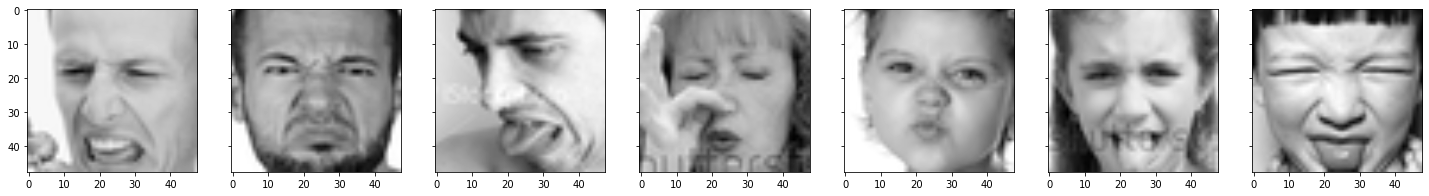

Selected Representatives for Emotion fear


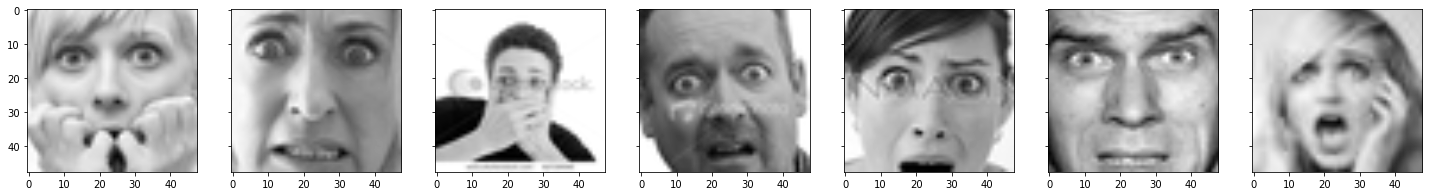

Selected Representatives for Emotion contempt


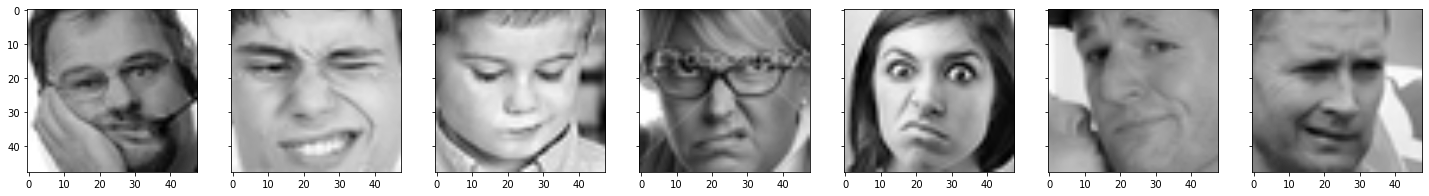

In [46]:
plot_reference_images(embedding_valid, ncols=7)

In [47]:
_, neighs_per_emotion_indices = get_neighbours(embedding_valid, n_neighbours=7)

In [48]:
neighs_per_emotion_indices

{'neutral': array([1121, 2143, 1690, 1883, 2137,  691, 1655]),
 'happy': array([ 175, 1562, 1629,  531, 1905,  900, 2566]),
 'surprise': array([1873, 1137,   79, 1827, 1882, 2588,  823]),
 'sad': array([ 232, 1552, 2514,  983,  206, 2269,  901]),
 'angry': array([1242, 1038,  555, 1496,  559,  989,  513]),
 'disgust': array([2501, 1291,  281, 2012,  384, 2342,  467]),
 'fear': array([1172, 2196, 2528, 1287,  704,  237, 1049]),
 'contempt': array([ 484, 1276, 2415,    0, 1349,  327, 2100])}

In [49]:
for emotion in neighs_per_emotion_indices:
    print(f"{emotion}: {list(neighs_per_emotion_indices[emotion])}")
    

neutral: [1121, 2143, 1690, 1883, 2137, 691, 1655]
happy: [175, 1562, 1629, 531, 1905, 900, 2566]
surprise: [1873, 1137, 79, 1827, 1882, 2588, 823]
sad: [232, 1552, 2514, 983, 206, 2269, 901]
angry: [1242, 1038, 555, 1496, 559, 989, 513]
disgust: [2501, 1291, 281, 2012, 384, 2342, 467]
fear: [1172, 2196, 2528, 1287, 704, 237, 1049]
contempt: [484, 1276, 2415, 0, 1349, 327, 2100]


#### Test Set 

**Note** Disabled to keep the size of the notebook low. 
Please de-comment to run locally!

In [ ]:
test_plot_with_centroids = plot_centroids(embedding_fig=test_plot, embedding=embedding_test)
show(test_plot_with_centroids)

In [ ]:
test_neighbours = plot_neighbours(embedding=embedding_test, n_neighbours=8)
test_neighbours.legend.location = "top_right"
show(test_neighbours)

In [ ]:
plot_reference_images(embedding_test, ncols=8)

In [ ]:
_, neighs_per_emotion_indices = get_neighbours(embedding_test, n_neighbours=8)

In [ ]:
for emotion in neighs_per_emotion_indices:
    print(f"{emotion}: {list(neighs_per_emotion_indices[emotion])}")
    